----

# <span style="color:darkred">Unsupervised NLP Analysis of Novelists</span>

__Author:__ Ryan Harper 

----

<a id="top"></a>

<a href='#ov'>Overview</a><br>
<a href='#exp'>Experiment</a><br>
<a href='#sec1'>1. Cleaning Data</a><br>
<a href='#sec2'>2. Word2Vec Embedding</a><br>
<a href='#sec2'>3. IDF Vectorization</a><br>
<a href='#sec3'>4. SVD Component Analysis</a><br>
<a href='#sec4'>5. Cluster Modeling</a><br>
<a href='#sec5'>6. Cluster Evaluation</a><br>

<a id="ov"></a>

# <span style="color:darkblue">Overview</span>  <a href='#top'>(top)</a>

__Data Source:__
> NLTK Gutenberg

__Summary:__
> This project explores the variation in vocabulary and writing structure of three different authors by employing Word2Vec, IDF, and a gaussian mixture cluster model to examine the sentences in three different novels.

__Variables:__
>__author:__ _author of the novel_<br>
__sentence:__ _sentence from the novel/author_ <br>

<a id="exp"></a>

# <span style="color:darkblue">Experiment</span> <a href='#top'>(top)</a>

__Hypothesis:__ 
> Authors will use different vocabulary and collocations that will help models predict differences between the authors in an unsupervised environment.

__Observations:__
><li> Proper nouns (names and places) are the strongest indicator of different authors (via their specific novels)<br><br>  <li> Some frequently used 1 and 2 word expressions (i.e.'Oh' and 'was said') are a good indicator of different authors <br><br>
  <li> Clustering models on a Truncated SVD IDF vector does not appear to produce meaningful results. Future experiments might need to explore other ways to better vectorize sentences for cluster models.

__Method:__
> Imported and merged the three novels into a data set - added a fourth novel from the first author to control for differences in novels<br><br>
> Split up the novels by sentences and random sampled the data.<br><br>
> Used IDF and SVD to assess important components and then matched them to the original sentences. <br><br>
> Used the Gaussian Mixture model (cluster model) to look at the three combined samples and to determine if clusters could be determined from sentences.<br><br>
> Used v_measurement and aikaike to assess the effectiveness of the clustering.

<a id="sec1"></a>

# <span style="color:darkblue">1. Cleaning the Data</span>  <a href='#top'>(top)</a>

In [1]:
%matplotlib inline
import numpy as np;import pandas as pd;import matplotlib.pyplot as plt
import scipy
import re
import sklearn;from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import gutenberg
from IPython.display import display
import warnings
import seaborn as sns
from textblob import TextBlob
warnings.filterwarnings('ignore')

In [2]:
from colorama import Fore
green = Fore.GREEN
red = Fore.RED
black = Fore.RESET

In [3]:
print(gutenberg.fileids())

['austen-emma.txt', 'austen-persuasion.txt', 'austen-sense.txt', 'bible-kjv.txt', 'blake-poems.txt', 'bryant-stories.txt', 'burgess-busterbrown.txt', 'carroll-alice.txt', 'chesterton-ball.txt', 'chesterton-brown.txt', 'chesterton-thursday.txt', 'edgeworth-parents.txt', 'melville-moby_dick.txt', 'milton-paradise.txt', 'shakespeare-caesar.txt', 'shakespeare-hamlet.txt', 'shakespeare-macbeth.txt', 'whitman-leaves.txt']


In [4]:
# Utility function for standard text cleaning.
def text_cleaner(text):
    text = str(text)
    # Visual inspection identifies a form of punctuation spaCy does not
    # recognize: the double dash '--'.  Better get rid of it now!
    text = re.sub(r'--',' ',text)
    text = re.sub("[\[].*?[\]]", "", text)
    text = re.sub('\n'," ",text)
    text = re.sub('\r'," ",text)
    return text

def mlist(story):
    return [text_cleaner(i) for i in TextBlob(re.sub(r'Chapter \d+', '', story)).sentences]

def mtokens(story):
    return [list(i.words.lower()) for i in TextBlob(re.sub(r'Chapter \d+', '', story)).sentences]

In [5]:
# Load and clean the data.
chestertonbrown = mlist(gutenberg.raw('chesterton-brown.txt'))
edgeworth = mlist(gutenberg.raw('edgeworth-parents.txt'))
alice = mlist(gutenberg.raw('carroll-alice.txt'))

In [6]:
sentences = chestertonbrown + alice + edgeworth

In [7]:
def nl(name,data):
    return [name for i in range(len(data))]
name = nl('chesterton',chestertonbrown)+nl('edgeworth',edgeworth)+nl('carroll',alice)

In [8]:
# Add second book to control for book differences (instead of author differences)
chestertonball = mlist(gutenberg.raw('chesterton-ball.txt'))
sentences+=chestertonball
name+=nl('chesterton',chestertonball)

In [9]:
stories = pd.DataFrame([sentences,name]).T.sample(frac=1,random_state=42)
stories.columns = ['sentence','author']

<a id="sec2"></a>

# 2. Word Embedding - Word2Vec

In [10]:
from gensim.models import word2vec
from gensim.utils import tokenize

In [11]:
stories.tokens = stories.sentence.apply(tokenize).apply(list)

In [12]:
%%time
load_model = False
 
vec_size = 200
word_vec = word2vec.Word2Vec(
    stories.tokens,
    workers=4,     # Number of threads to run in parallel
    min_count=5,  # Minimum word count threshold.
    window=6,      # Number of words around target word to consider.
    sg=0,          # Use CBOW because our corpus is small.
    sample=1e-3 ,  # Penalize frequent words.
    size=vec_size,      # Word vector length.
    hs=1           # Use hierarchical softmax.
)

# List of words in model.
vocab = word_vec.wv.vocab.keys()

CPU times: user 6.92 s, sys: 34.1 ms, total: 6.95 s
Wall time: 2.16 s


__Cosine Similarity Function__

$$ cos(\theta) = \frac{A \bullet B} {\Vert A \Vert \Vert B \Vert} =  \frac{\sum_{i=1}^n A_i B_i}{\sqrt{ \sum_{i=1}^n A^2} \sqrt{ \sum_{i=1}^n B^2}} $$

__Version A. Cosine Similarity Function on Word2Vec Matrix (with numpy)__

In [13]:
euclidean_norm = lambda m: np.sqrt(np.array([a*a for a in m]).sum())
def similarity_vec(a,b):
    return (np.dot(a,b))/(euclidean_norm(a)*euclidean_norm(b))

ladyship_miss = similarity_vec(word_vec['ladyship'],word_vec['Miss'])
ladyship_statue = similarity_vec(word_vec['ladyship'],word_vec['statue'])
statue_miss = similarity_vec(word_vec['statue'],word_vec['Miss'])
bore_hard = similarity_vec(word_vec['bore'],word_vec['hard'])

print(green+'ladyship - Miss: {}'.format(ladyship_miss)+black)
print(red+'ladyship - statue: {}'.format(ladyship_statue)+black)
print(red+'statue - Miss: {}'.format(statue_miss)+black)
print(green+'bore - hard: {}'.format(bore_hard)+black)

ladyship - Miss: 0.6202283501625061
ladyship - statue: 0.19411465525627136
statue - Miss: 0.06034122034907341
bore - hard: 0.6270266175270081


__Version B. Gensim__

In [14]:
w1,w2,w3 = 'Miss','ladyship','men'
print(word_vec.wv.most_similar(positive=[w1, w2], negative=[w3], topn=1))

w1 = 'statue'
print(word_vec.wv.most_similar(positive=w1,topn=3))

w1 = 'hard'
print(word_vec.wv.most_similar(positive=w1,topn=3))

[('mother', 0.7773891687393188)]
[('restaurant', 0.8764076232910156), ('engine', 0.8655489683151245), ('unknown', 0.8647832870483398)]
[('whistle', 0.7745720148086548), ('grotesque', 0.7595998048782349), ('tame', 0.7530933022499084)]


__Version C. SKlearn__

In [15]:
from sklearn.metrics.pairwise import cosine_similarity

In [16]:
cosine_similarity(word_vec['ladyship'].reshape(-1,1),word_vec['Miss'].reshape(-1,1))

array([[ 1., -1.,  1., ...,  1.,  1., -1.],
       [-1.,  1., -1., ..., -1., -1.,  1.],
       [ 1., -1.,  1., ...,  1.,  1., -1.],
       ...,
       [ 1., -1.,  1., ...,  1.,  1., -1.],
       [-1.,  1., -1., ..., -1., -1.,  1.],
       [-1.,  1., -1., ..., -1., -1.,  1.]], dtype=float32)

_Returns a matrix for first part of cosine similarity equation_

## _Word Similarity Visualization_

In [17]:
colors_dict = dict(zip(['statue','Miss','ladyship'],['red','green','green']))

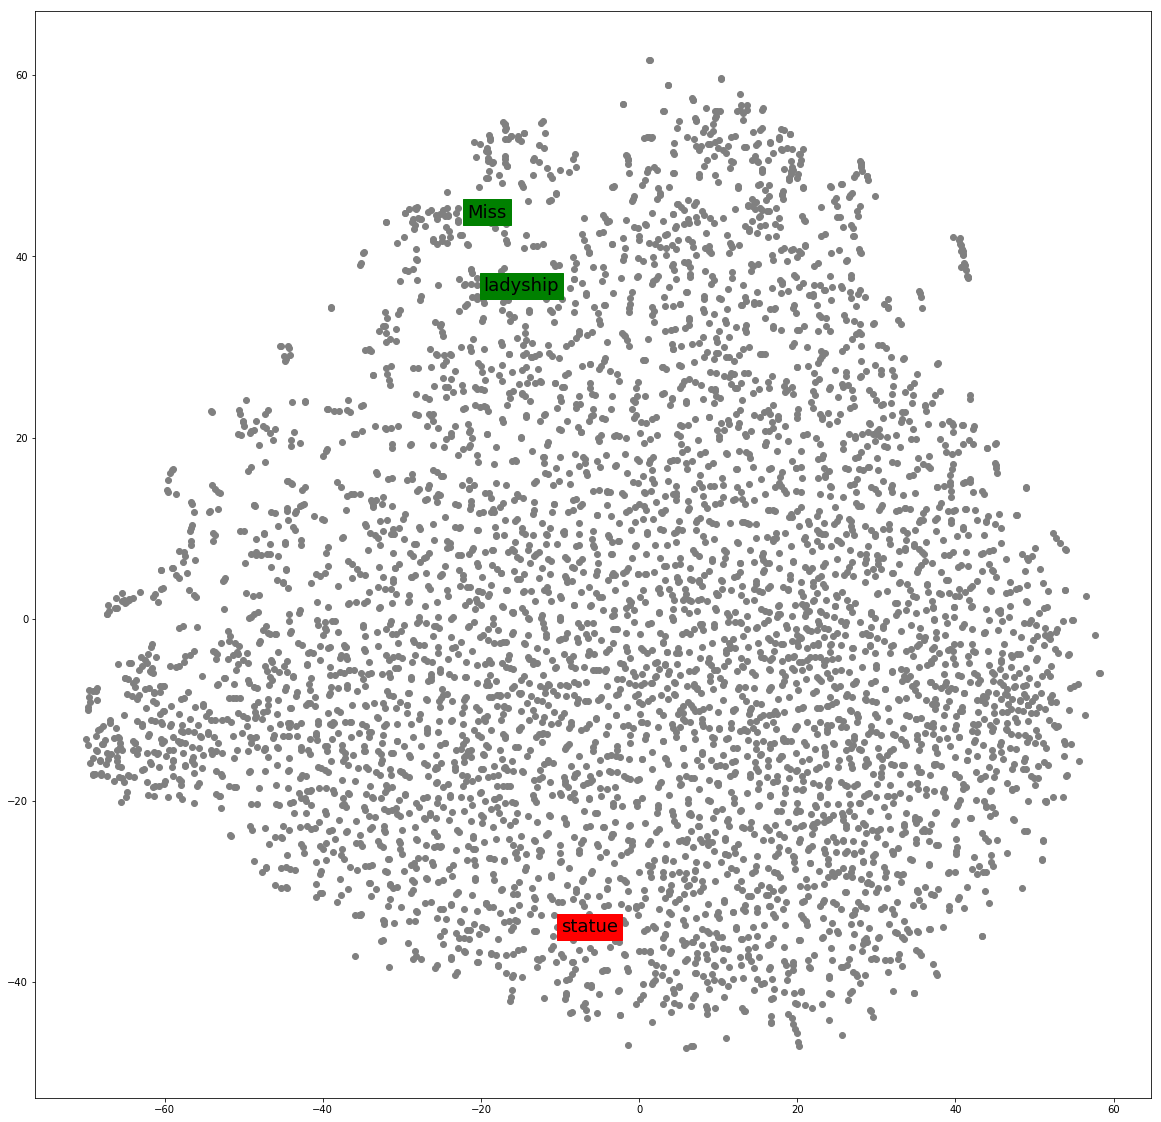

In [18]:
from sklearn.manifold import TSNE
X = word_vec[word_vec.wv.vocab]
words = list(word_vec.wv.vocab)
graph_tsne = TSNE(n_components=2)
result = graph_tsne.fit_transform(X)
# create a scatter plot of the projection
plt.figure(figsize=(20,20))
plt.scatter(result[:, 0], result[:, 1],color='gray')
for i, word in enumerate(words):
    if word in colors_dict.keys():
        plt.annotate(word, 
                     xy=(result[i, 0], 
                         result[i, 1]),
                     size=18,
                     backgroundcolor=colors_dict[word])
plt.show()

<a id="sec3"></a>

# <span style="color:darkblue">3. IDF Vectorization</span>  <a href='#top'>(top)</a>

In [19]:
vectorizer = TfidfVectorizer(max_df=0.3,
                             min_df=2,
                             stop_words='english', 
                             lowercase=True, #lower case
                             use_idf=True,#inverse document frequencies
                             norm=u'l1', #longer and shorter paragraphs get treated equally
                             smooth_idf=True #Adds 1 to all document frequencies
                            )

X_train, y_train = stories.sentence,stories.author

#Applying the vectorizer
stories_paras_tfidf=vectorizer.fit_transform(X_train)
print("Number of features: %d" % stories_paras_tfidf.get_shape()[1])

Number of features: 9040


In [20]:
# Reformat tfidf (Thinkful code)
X_train_tfidf_csr = stories_paras_tfidf.tocsr()

n = X_train_tfidf_csr.shape[0]

tfidf_bypara = [{} for _ in range(0,n)]

_Examine Features_

In [21]:
#List of features
terms = vectorizer.get_feature_names()

#for each paragraph, lists the feature words and their tf-idf scores
for i, j in zip(*X_train_tfidf_csr.nonzero()):
    tfidf_bypara[i][terms[j]] = X_train_tfidf_csr[i, j]

#Keep in mind that the log base 2 of 1 is 0
print('Original sentence:', stories.iloc[0])
print('Tf_idf vector:', tfidf_bypara[10])

Original sentence: sentence    cried her mother; "come to me, and tell me  wh...
author                                              edgeworth
Name: 8214, dtype: object
Tf_idf vector: {'said': 0.3388014198339718, 'archer': 0.6611985801660282}


<a id="sec4"></a>

# <span style="color:darkblue">4. SVD Component Analysis</span>  <a href='#top'>(top)</a>

In [22]:
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

In [23]:
variances = []
r = range (1,7001,500)
for i in r:
    svd= TruncatedSVD(i)
    lsa = make_pipeline(svd, Normalizer(copy=False))
    # Run SVD on the training data, then project the training data.
    X_train_lsa = lsa.fit_transform(X_train_tfidf_csr)
    variance_explained=svd.explained_variance_ratio_
    total_variance = variance_explained.sum()
    variances.append(total_variance)
    print('# of Features: {}'.format(i),end=' | ')

# of Features: 1 | # of Features: 501 | # of Features: 1001 | # of Features: 1501 | # of Features: 2001 | # of Features: 2501 | # of Features: 3001 | # of Features: 3501 | # of Features: 4001 | # of Features: 4501 | # of Features: 5001 | # of Features: 5501 | # of Features: 6001 | # of Features: 6501 | 

Text(0.5,1,'Truncated SVD: Explained Variance')

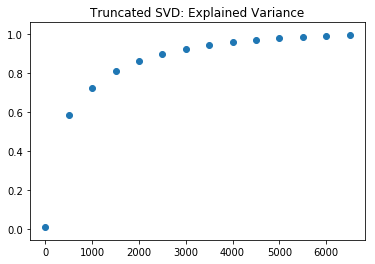

In [24]:
plt.scatter(r,variances)
plt.title('Truncated SVD: Explained Variance')

In [25]:
svd= TruncatedSVD(400)
lsa = make_pipeline(svd, Normalizer(copy=False))
# Run SVD on the training data, then project the training data.
X_train_lsa = lsa.fit_transform(X_train_tfidf_csr)
variance_explained=svd.explained_variance_ratio_
total_variance = variance_explained.sum()

In [26]:
#Looking at what sorts of paragraphs our solution considers similar
paras_by_component=pd.DataFrame(X_train_lsa,index=X_train.index)
paras_by_component['author'] = stories.author
paras_by_component['sentence'] = stories.sentence

In [27]:
pd.options.display.width = 100
pd.options.display.max_colwidth = 100

In [28]:
for i in range(5):
    component = i
    print('Component {}:'.format(component))
    df = pd.DataFrame(data = paras_by_component[[component,'author','sentence']]).sort_values(by=component,ascending=False)[0:40:5]
    df = df.reset_index();del df['index'];df.columns=['Similarity','Author','Sentence']
    display(df)
    print('')

Component 0:


,Similarity,Author,Sentence
0,0.973342,edgeworth,said I.
1,0.973342,chesterton,He said something or nothing.
2,0.973342,edgeworth,said he.
3,0.973342,edgeworth,"""Very well,"" said she."
4,0.973342,edgeworth,said the others.
5,0.973342,chesterton,he said.
6,0.973342,chesterton,he said.
7,0.971554,edgeworth,said the Eaglet.



Component 1:


,Similarity,Author,Sentence
0,0.982147,edgeworth,"""Oh!"
1,0.982147,chesterton,"""Oh!"""
2,0.982147,edgeworth,"""Oh!"
3,0.982147,edgeworth,"Oh, how could you do so?"""
4,0.982147,edgeworth,Oh!
5,0.982147,carroll,Oh!
6,0.982147,carroll,"""Oh!"""
7,0.982147,edgeworth,"""Oh!"""



Component 2:


,Similarity,Author,Sentence
0,0.989295,edgeworth,Just.
1,0.989295,edgeworth,Just.
2,0.989295,edgeworth,Just.
3,0.989295,edgeworth,Just.
4,0.989295,edgeworth,Just.
5,0.989295,edgeworth,Just.
6,0.989295,edgeworth,Just as much.
7,0.989295,edgeworth,Just.



Component 3:


,Similarity,Author,Sentence
0,0.991301,edgeworth,Lord J.
1,0.991301,edgeworth,Lord J.
2,0.991301,edgeworth,Lord J.
3,0.991301,edgeworth,Lord J.
4,0.991301,edgeworth,Lord J.
5,0.991301,chesterton,Lord!
6,0.991301,edgeworth,Lord J.
7,0.991301,edgeworth,Lord J.



Component 4:


,Similarity,Author,Sentence
0,0.999998,edgeworth,Wheel.
1,0.999998,edgeworth,Wheel.
2,0.999998,edgeworth,Wheel.
3,0.999998,edgeworth,Wheel.
4,0.999998,edgeworth,Wheel.
5,0.999998,edgeworth,Wheel.
6,0.999998,edgeworth,Wheel.
7,0.999998,edgeworth,Wheel.


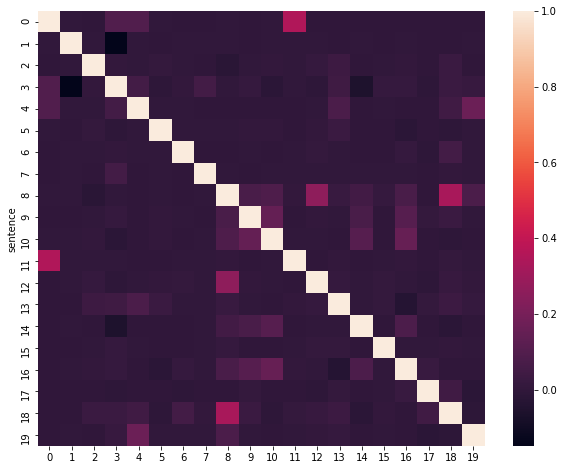

Key:
0-edgeworth: cried her mother; "come to me, and tell me  what's the matter."
1-edgeworth: it asked.
2-chesterton: Then MacIan stopped suddenly and planted his sword-point in the ground like one who plants his tent-
3-edgeworth: "What!
4-carroll: "Well, then," cried Tarlton, giving his hand to the boy next him, then to  the next, "your word and 
5-edgeworth: Without determining which species of love is the most flattering to  others, we can easily decide wh
6-edgeworth: "Shall we walk out before tea?"
7-chesterton: He was one of those amateurs who always know more than the professional.
8-chesterton: "Then, why," said the large man in the silk hat, trembling from head to foot, "why do you wear your 
9-edgeworth: "Well," said Susan, "I am not too proud to be obliged.
10-edgeworth: said Archer.
11-edgeworth: All I understand is the  common honesty of the matter.
12-chesterton: Beyond it lay the broad sombrero fallen from the head of Muscari, and beside it a sealed business le
13-ches

In [29]:
r = range(0,20)
# Compute document similarity using LSA components
similarity = np.asarray(np.asmatrix(X_train_lsa) * np.asmatrix(X_train_lsa).T)
#Only taking the first 10 sentences
sim_matrix=pd.DataFrame(similarity,index=X_train).iloc[r[0]:r[-1]+1,r[0]:r[-1]+1]
#Making a plot
plt.figure(figsize=(10,8))
ax = sns.heatmap(sim_matrix,yticklabels=r)
plt.show()

#Generating a key for the plot.
print('Key:')
for i in r:
    j = i-r[0]
    print("{}-{}: {}".format(i,stories.author.iloc[i],sim_matrix.index[j][0:100]))

<a id="sec4"></a>

# <span style="color:darkblue">5. Cluster Model - Gaussian Mixture</span>  <a href='#top'>(top)</a>

_Because four novels (and three authors) were merged into a single data set, a mixture model is helpful for distinguising between_

In [30]:
%%time
from sklearn.mixture import GaussianMixture

gm_range = range(2,8,1)
gm_aic = []
gm_predict = []
gm_score = []

gm_x = X_train_lsa
gm_y = y_train
for i in gm_range:
    # Declare and fit the model.
    gm = GaussianMixture(n_components=i,n_init=10,init_params='random')
    gm.fit(gm_x)
    # gm_predict.append(km.predict_fit(X_test_tfidf))
    gm_aic.append(gm.aic(gm_x))
    gm_predict.append(gm.predict(gm_x))
    gm_score.append(gm.score(gm_x,gm_y))
    
    
    #Predicted clusters.
    print('{} completed'.format(i),end=' | ')

2 completed | 3 completed | 4 completed | 5 completed | 6 completed | 7 completed | CPU times: user 2h 50min 5s, sys: 13min 10s, total: 3h 3min 16s
Wall time: 1h 39min 39s


<a id="sec2"></a>

# 6. Cluster Analysis

## _AIC (Aikaike Information Criterion)_

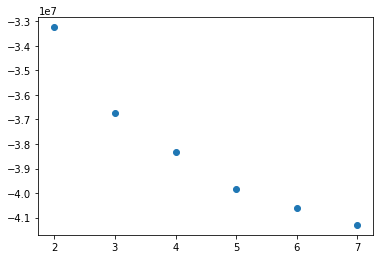

In [31]:
plt.scatter(range(2,8,1),gm_aic)
plt.savefig('aic.jpg')

## _V-Measurement Criterion_

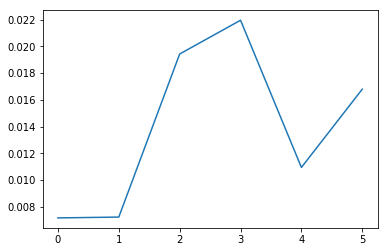

In [33]:
from sklearn.metrics import v_measure_score
v_score = []
for score in gm_predict:
    v_score.append(v_measure_score(y_train,score))
    
plt.plot(v_score);

## _Cross Tab_

In [34]:
table = pd.crosstab(y_train, gm_predict[1],margins = True)
table.index = list(y_train.unique()) + ['total'];table

col_0,0,1,2,All
edgeworth,856,460,309,1625
chesterton,4637,2203,1496,8336
carroll,4546,2835,2715,10096
total,10039,5498,4520,20057
